In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(123)

### Bandit 변수 세팅

In [4]:
N_TRIAL = 2000              # round 수                  > 적정선 찾는 과정 필요
N_ARMS = 16                 # arm 수 (밴딧 수)          > 지면 수
N_FEATURE  = 5              # feature 수                > N개
BEST_ARMS = [3, 7, 9, 15]   # 임의 설정 (최적의 bandit)  > truth 값 존재

In [5]:
def make_design_matrix(n_trial, n_arms, n_feature):     # 임의로 context 생성 (trial, arm, dim_feature)
    available_arms = np.arange(n_arms)
    X = np.array([[np.random.uniform(low=0, high=1, size=n_feature) for _ in available_arms] for _ in np.arange(n_trial)])
    return X

In [6]:
D = make_design_matrix(N_TRIAL, N_ARMS, N_FEATURE)

In [7]:
D.shape

(2000, 16, 5)

In [8]:
def make_theta(n_arms, n_feature, best_arms, bias = 1):     # 임의로 theta 생성 > best에는 1을 더함 (arms, dim_feature)
    true_theta = np.array([np.random.normal(size=n_feature, scale=1/4) for _ in np.arange(n_arms)])  # 표준편차 = 1/4
    true_theta[best_arms] = true_theta[best_arms] + bias
    return true_theta

In [9]:
theta = make_theta(N_ARMS, N_FEATURE, BEST_ARMS, bias=1)

In [10]:
theta.shape

(16, 5)

In [12]:
def generate_reward(arm, x, theta, scale_noise = 1/10):
    signal = theta[arm].dot(x)                              # theta[arm] : theta of num_arm ///  x : X[a,b], a번째 trial의 b번째 arm의 context
    noise = np.random.normal(scale=scale_noise)
    return (signal + noise)

In [13]:
def make_regret(payoff, oracle):
    return np.cumsum(oracle - payoff)

In [14]:
X = make_design_matrix(n_trial=N_TRIAL, n_arms= N_ARMS, n_feature=N_FEATURE)
true_theta = make_theta(n_arms = N_ARMS, n_feature=N_FEATURE, best_arms=BEST_ARMS)

In [15]:
# Average reward
ave_reward = np.mean([[generate_reward(arm=arm, x=X[t, arm], theta= true_theta) for arm in np.arange(N_ARMS)] for t in np.arange(N_TRIAL)], axis=0)
# X[t, arm] : t번째 trial의 arm 번호의 context
# 매 trial 마다 > 매 arm의 > (Context) dot (theta)
# output : num_arm 차원의 reward 평균 값 

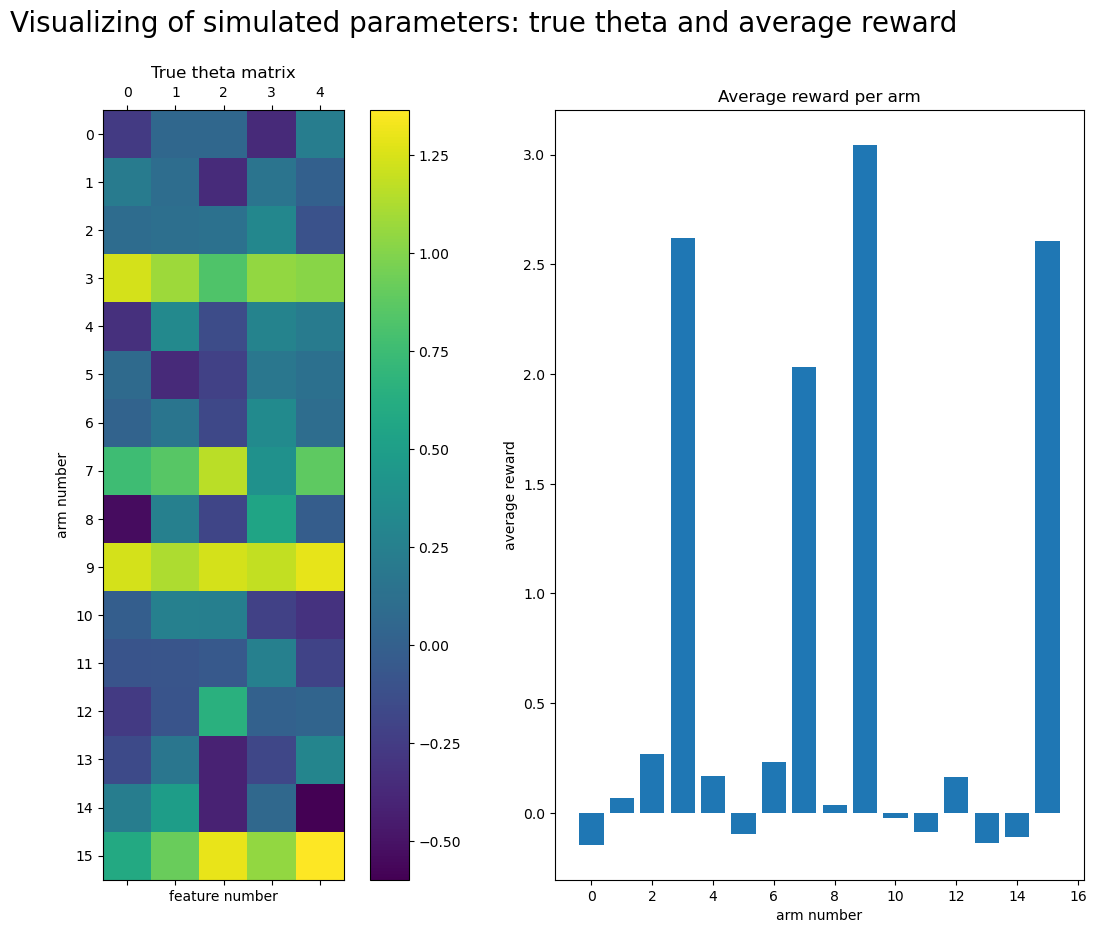

In [20]:
f, (left, right) = plt.subplots(1, 2, figsize=(15, 10))
f.suptitle(t="Visualizing of simulated parameters: true theta and average reward", fontsize=20)
# True theta
left.matshow(true_theta)
f.colorbar(left.imshow(true_theta), ax = left)
left.set_xlabel("feature number")
left.set_ylabel("arm number")
left.set_yticks(np.arange(N_ARMS))
left.set_title("True theta matrix")
# Average reward
right.bar(np.arange(N_ARMS), ave_reward)
right.set_title("Average reward per arm")
right.set_xlabel("arm number")
right.set_ylabel("average reward")
plt.show()

In [48]:
 A = np.array([np.diag(np.ones(shape=6)) for _ in np.arange(16)]) # (16, 6, 6)

In [49]:
A

array([[[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
      

In [52]:
b = np.array([np.zeros(shape=5) for _ in np.arange(16)]) # (16, 5)

In [53]:
b.shape

(16, 5)

In [54]:
def linUCB_disjoint(alpha, X, generate_reward, true_theta):
    print("linUCB disjoint with exploration parameter alpha: ", alpha)
    n_trial, n_arms, n_feature = X.shape
    # 1. Initialize object
    # 1.1. Output object
    arm_choice = np.empty(n_trial) # store arm choice (integer) for each trial
    r_payoff = np.empty(n_trial) # store payoff (float) for each trial
    theta = np.empty(shape=(n_trial, n_arms, n_feature)) # record theta over each trial (n_arms, n_feature) per trial
    p = np.empty(shape = (n_trial, n_arms)) # predictions for reward of each arm for each trial
    # 1.2 Intermediate object
    A = np.array([np.diag(np.ones(shape=n_feature)) for _ in np.arange(n_arms)])
    b = np.array([np.zeros(shape=n_feature) for _ in np.arange(n_arms)])
    # 2. Algo
    for t in np.arange(n_trial):
        # Compute estimates (theta) and prediction (p) for all arms
        for a in np.arange(n_arms):
            inv_A = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a])
            p[t, a] = theta[t, a].dot(X[t, a]) + alpha * np.sqrt(X[t, a].dot(inv_A).dot(X[t, a]))
        # Choosing best arms
        chosen_arm = np.argmax(p[t])
        x_chosen_arm = X[t, chosen_arm]
        r_payoff[t] = generate_reward(arm=chosen_arm, x=x_chosen_arm, theta=true_theta)

        arm_choice[t] = chosen_arm
        
        # update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoff[t]*x_chosen_arm
    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoff=r_payoff)

In [55]:
oracle = np.array([np.max([generate_reward(arm=arm, x=X[t, arm], theta = true_theta) for arm in np.arange(N_ARMS)]) for t in np.arange(N_TRIAL)])

In [ ]:
# 임시로 oracle을 생성 

In [56]:
len(oracle)

2000

In [57]:
oracle[0]

3.8311314255495628

In [58]:
payoff_random = np.array([generate_reward(arm=np.random.choice(N_ARMS), x= X[t, np.random.choice(N_ARMS)], theta = true_theta) for t in np.arange(X.shape[0])])

In [59]:
payoff_random

array([-0.20112755, -0.10514424, -0.13938686, ...,  0.41623397,
        3.48419023,  0.15822457])

In [60]:
regret_random = make_regret(payoff=payoff_random, oracle=oracle)

In [61]:
alpha_to_test = [0, 1, 2.5, 5, 10, 20]
results_dict = {alpha: linUCB_disjoint(alpha=alpha, X=X, generate_reward=generate_reward, true_theta = true_theta) for alpha in alpha_to_test}

linUCB disjoint with exploration parameter alpha:  0
linUCB disjoint with exploration parameter alpha:  1
linUCB disjoint with exploration parameter alpha:  2.5
linUCB disjoint with exploration parameter alpha:  5
linUCB disjoint with exploration parameter alpha:  10
linUCB disjoint with exploration parameter alpha:  20


In [62]:
def plot_regrets(results, oracle):
    [plt.plot(make_regret(payoff=x['r_payoff'], oracle=oracle), label="alpha: "+str(alpha)) for (alpha, x) in results.items()]

In [63]:
def plot_estimates(x, alpha, true_theta=None, abs_ylim = None, ncol = 4):
    print("Estimates plot for alpha: ", alpha)
    if true_theta is not None:
        print("Parameter true_theta has been supplied. Plotting convergence")
    for i, arm in enumerate(np.arange(N_ARMS)):
        plt.subplot(np.ceil(N_ARMS/ncol), ncol, 1+i)
        if true_theta is not None:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, :]) - true_theta[arm]
        else:
            data_to_plot = pd.DataFrame(x[alpha]["theta"][:, arm, ])
        plt.plot(data_to_plot)
        
        if (arm in BEST_ARMS):
            title = 'Arm: ' + str(arm) + " (best)"
        else:
            title = "Arm: " + str(arm)
        plt.title(title)
        
        if abs_ylim is not None:
            plt.ylim([-abs_ylim, abs_ylim])
    plt.legend(["c"+str(feature) for feature in np.arange(N_FEATURE)])

In [64]:
def plot_selected_arms(x, bar_width=0.15):
    for (i, alpha) in enumerate(x):
        xi, yi = np.unique(x[alpha]["arm_choice"], return_counts=True)
        plt.bar(xi + i*bar_width, yi, label="alpha: " + str(alpha), width=bar_width)
    
    plt.xticks(np.arange(N_ARMS) + round(len(x)/2)*bar_width, np.arange(N_ARMS))
    plt.legend()

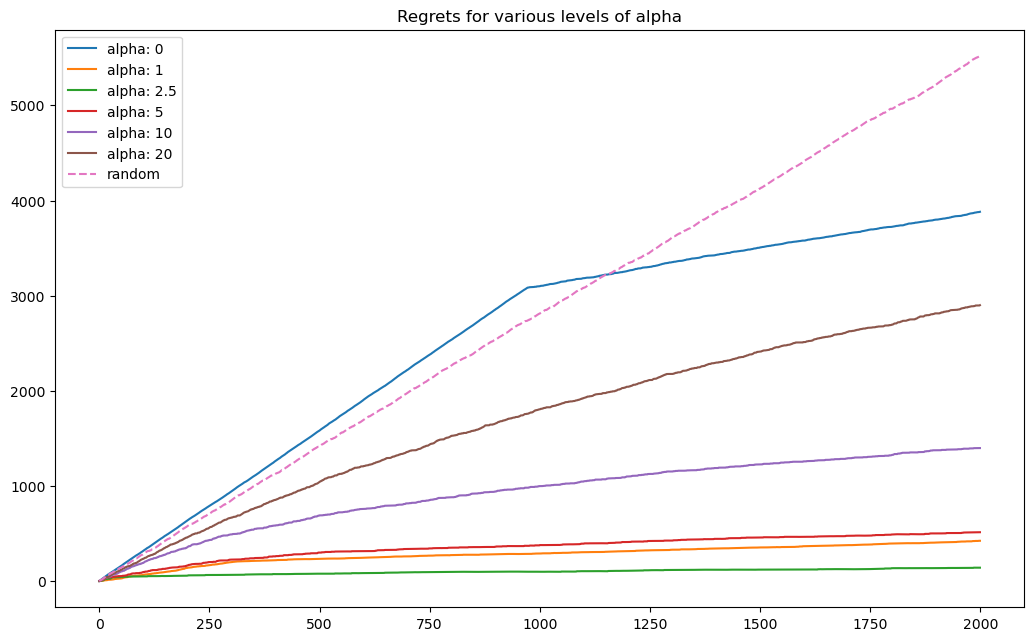

In [65]:
plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, oracle)
plt.plot(make_regret(payoff=payoff_random, oracle=oracle), label = "random", linestyle='--')
plt.legend()
plt.title("Regrets for various levels of alpha")
plt.show()

In [66]:
plt.figure(figsize=(12.5, 17.5))
plot_estimates(results_dict, alpha=2.5, true_theta = true_theta, abs_ylim=3/4)

Estimates plot for alpha:  2.5
Parameter true_theta has been supplied. Plotting convergence


ValueError: Number of rows must be a positive integer, not 4.0

<Figure size 1250x1750 with 0 Axes>

In [ ]:
plt.figure(figsize=(12.5, 17.5))
plot_estimates(results_dict, alpha=20, true_theta=true_theta, abs_ylim=3/4)

Estimates plot for alpha:  20
Parameter true_theta has been supplied. Plotting convergence


ValueError: Number of rows must be a positive integer, not 4.0

<Figure size 1250x1750 with 0 Axes>

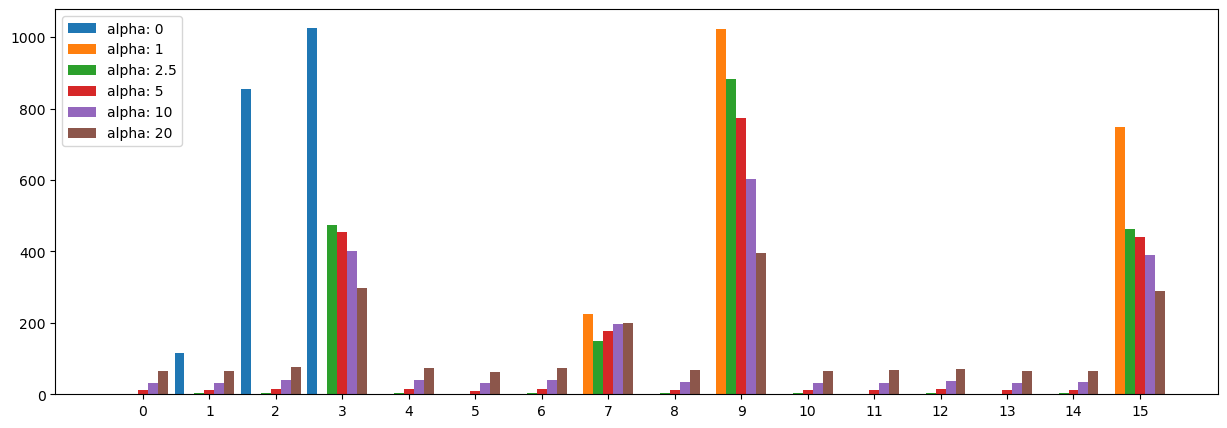

In [67]:
plt.figure(figsize=(15, 5))
plot_selected_arms(results_dict)